**тематическое моделирование**

_Евгений Борисов <esborisov@sevsu.ru>_

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

pd.options.display.precision = 2 
pd.options.display.max_colwidth = 200 
tqdm.pandas()

Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation   
http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [ ]:
# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## загрузка данных

датасет news.pkl.gz  
https://disk.yandex.ru/d/8_T_XITkZ4gKAw

In [2]:
# загружаем тексты
data = pd.read_pickle('news.pkl.gz')
display( len(data) )
display( data.sample(2) )

3196

text  \
70                                                                                          Пример установки Gentoo LinuxDmitry G Zimin написал статью в которой\nкратко показал как установить Gentoo Linux.   
2940  Как сообщается, причиной данного решения является повышение конкуренции со стороны современных переднеприводных автомоделей. Строительство транспортных средствна новой платформе позволит испытать ...   

       tag  
70    tech  
2940  auto

In [3]:
display( len( data.drop_duplicates('text') ) )

3196

## токенайзер

In [4]:
# NLTK package manager
# import nltk
# nltk.download()

In [5]:
import re
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [6]:
# def tokenizer(text):
#     return [
#             t for t in nltk_tokenize_word( # разбиваем текст на слова
#                 re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
#                 language='russian'
#             ) 
#         ]

In [7]:
# stemmer = SnowballStemmer('russian')

from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t for t in nltk_tokenize_word( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
                language='russian'
            ) 
            if not (
               False
               or (len(t)<3) # выкидываем очень короткие слова
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
               or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
            )
        ] 

## выполняем частотный анализ

In [8]:
# from sklearn.feature_extraction.text import CountVectorizer
# tf_model = CountVectorizer(
#         min_df=.01, # выкидываем очень редкие слова
#         max_df=.10, # выкидываем очень частые слова
#         tokenizer=tokenizer, # ф-ция токенайзер
#         token_pattern=None, # отключаем дефолтный токенайзер
#         # binary=True,
#     )

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_model = TfidfVectorizer(
        min_df=.01, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

In [10]:
%%time

data_tf = tf_model.fit_transform( data['text'] )

display(data_tf.shape)

(3196, 2021)

CPU times: user 4.74 s, sys: 17.2 ms, total: 4.76 s
Wall time: 4.76 s


In [11]:
vocab = sorted(tf_model.vocabulary_)
display(len(vocab))
display(vocab)

2021

['adobe',
 'afisha.tut.by',
 'apple',
 'audi',
 'auto.tut.by',
 'facebook',
 'finance.tut.by',
 'flash',
 'html5',
 'http',
 'javascript',
 'journal',
 'kia',
 'lenta.ru',
 'news',
 'player',
 'realty.tut.by',
 'regnum',
 'reuters',
 'sport.tut.by',
 'street',
 'telegram',
 'the',
 'times',
 'tut.by',
 'twitter',
 'volkswagen',
 'wall',
 'youtube',
 'абсолютно',
 'аварии',
 'авария',
 'августа',
 'августе',
 'авто',
 'автобуса',
 'автомобилей',
 'автомобилем',
 'автомобили',
 'автомобиль',
 'автомобиля',
 'автор',
 'авторы',
 'агентства',
 'агентство',
 'администрации',
 'адрес',
 'актер',
 'активно',
 'активность',
 'акции',
 'акций',
 'александр',
 'александра',
 'александром',
 'алексей',
 'алеппо',
 'американская',
 'американские',
 'американский',
 'американских',
 'американского',
 'американской',
 'америки',
 'анализ',
 'аналитики',
 'андрей',
 'андрея',
 'анна',
 'армии',
 'ассоциации',
 'атмосферу',
 'базе',
 'базовой',
 'банк',
 'банка',
 'безопасности',
 'беларуси',
 'белару

## извлечение списка тем и ключевых слов

In [12]:
# извлекаем из модели список тем и ключевых слов
def extract_topics( components, feature_names, n_top_words=3 ):
    return {
        topic_idx : [ feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1] ]
        for topic_idx, topic in enumerate(components)
    }

In [13]:
# from sklearn.decomposition import LatentDirichletAllocation
# # LDA - латентное размещение Дирихле
# tm_model = LatentDirichletAllocation( 
#         n_components=10, 
#         max_iter=5,
#         learning_method='online', 
#         learning_offset=50.,
#         random_state=0, 
#     )

In [14]:
from sklearn.decomposition import NMF
# NMF (generalized Kullback-Leibler divergence) 

tm_model = NMF( 
        n_components=10,
        random_state=1, 
        beta_loss='kullback-leibler', 
        solver='mu', 
        max_iter=1000, 
        l1_ratio=.5 
    )

In [15]:
data['topic_id'] = np.argmax( tm_model.fit_transform(data_tf),axis=1)

In [16]:
# список тем и ключевых слов
topics = extract_topics( tm_model.components_, vocab )
display( topics )

{0: ['беларуси', 'tut.by', 'беларусь'],
 1: ['президент', 'президента', 'трамп'],
 2: ['рублей', 'компании', 'долларов'],
 3: ['результате', 'дтп', 'водитель'],
 4: ['версия', 'новый', 'видео'],
 5: ['народов', 'севера', 'коренных'],
 6: ['ученые', 'специалисты', 'алеппо'],
 7: ['савченко', 'украины', 'суд'],
 8: ['место', 'динамо', 'чемпионата'],
 9: ['стал', 'фильм', 'мира']}

---

In [ ]:
# распределение текстов по темам
# data.groupby(['topic_id']).size().plot.bar(rot=0)

In [17]:
topics_ = { k:f'{k}: ' + ' | '.join(v) for k,v in topics.items() }
tags = sorted(set(data['tag']))

topic_tags = (
    data[['tag','topic_id']]
    .groupby('topic_id')['tag']
    .apply(lambda t_tags: { t: len([w for w in t_tags if w==t]) for t in tags } )
    .reset_index()
    .rename(columns={'level_1':'tag','tag':'count',})
    .apply(lambda d: d.map(topics_) if d.name =='topic_id' else d)
    .pivot(index='topic_id', columns='tag', values='count')
)

display( topic_tags.style.background_gradient(cmap='Blues') )

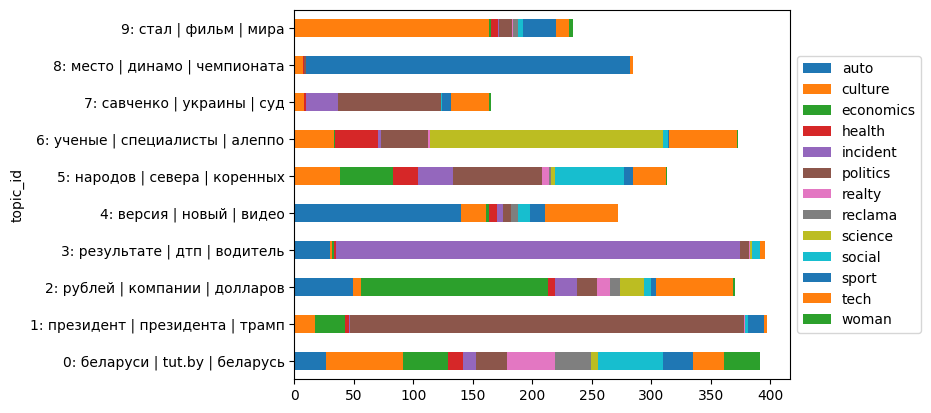

In [18]:
( # распределение количества текстов по темам с долями меток
topic_tags
.plot.barh(stacked=True) #,rot=0)
.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
)

---

In [19]:
data['keywords'] = data['topic_id'].map(topics)
display( data.sample(4) )

text  \
1890  Неизвестный ранее эскиз Леонардо да Винчи обнаружили искусствоведы в Париже. Набросок, на котором изображен Святой Себастьян, преданный мученической смерти, оценивается в 16 миллионов долларов.\n\...   
2500  \r\nФото: Фонтанка.ру\r\n\r\nНа «Ленфильме» представят лучшие исторические книги\r\n\r\nРейтинг:*****\r\n\r\nВыставка исторической литературы появилась в Петербурге в 2015 году и тогда казалась эк...   
459   Канцлер Германии добивается частичного запрета паранджи и никаба\n\n6 декабря 2016 в 18:12\n\nМарина Барановская, Deutsche Welle\n\nАнгела Меркель заявила, что паранджа и никаб должны быть запреще...   
221   В Екатеринбурге 2 декабря стартует очередной круглосуточный киномарафон.\nАкция будет проходить с 12:00 2 декабря до 12:00 3 декабря в кинотеатре\n"Салют". За это время участникам марафона будет п...   

           tag  topic_id                        keywords  
1890   culture         9             [стал, фильм, мира]  
2500   culture         9             [стал, фильм, мира]  
459   politics         1  [президент, президента, трамп]  
221    culture         5     [народов, севера, коренных]